In [21]:
import numpy as np, pandas as pd 
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier

from math import sqrt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import streamlit as st
from sklearn.preprocessing import  LabelEncoder

trainingData = pd.read_csv('train.csv')
testingData = pd.read_csv('test.csv')

trainingData.shape
#trainingData.info()



(3000, 23)

In [22]:
trainingData.describe()


,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [23]:
trainingData.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

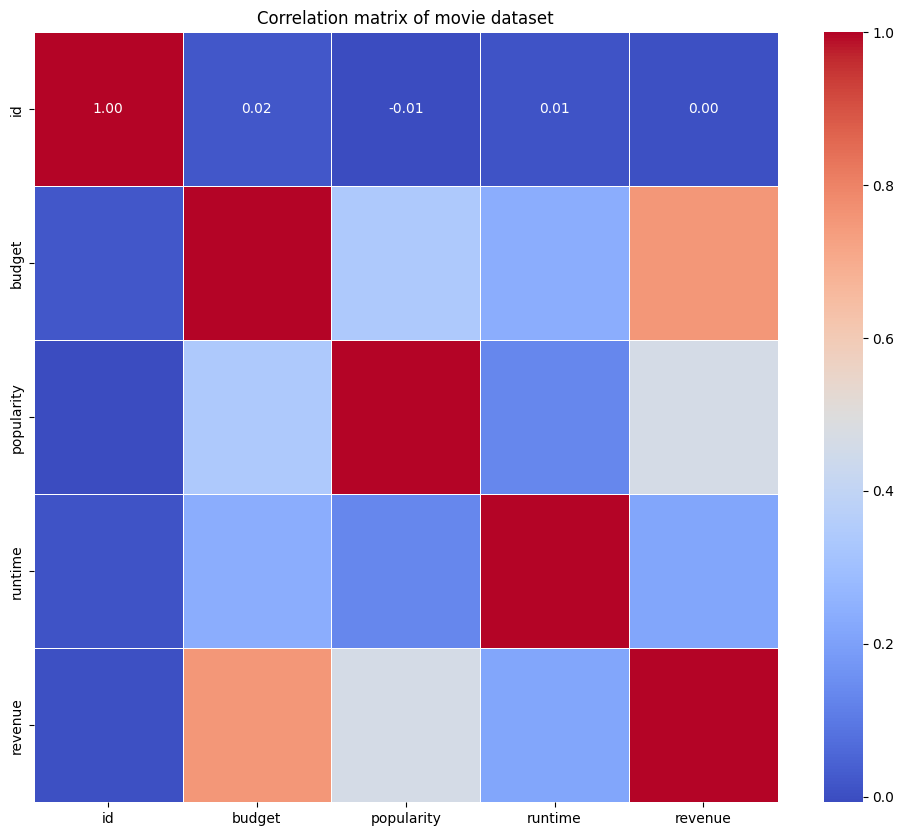

In [24]:
import matplotlib.pyplot as plt

numeric_data = trainingData.select_dtypes(include=[np.number])
# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
# 'annot=True' to write the data value in each cell
# 'cmap' to choose the color palette
# 'fmt' to format the annotation if 'annot' is True
# 'linewidths' to set the width of the lines that will divide each cell
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Add a title to the heatmapx
plt.title('Correlation matrix of movie dataset')

# Show the plot
plt.show()


C:\Users\torbe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\torbe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


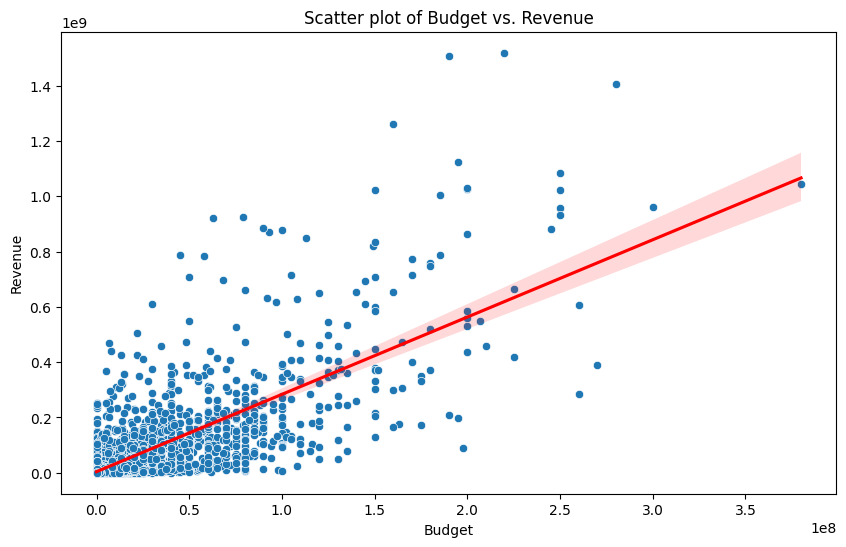

In [25]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='budget', y='revenue', data=trainingData)

# Adding a trend line to see the correlation more clearly
sns.regplot(x='budget', y='revenue', data=trainingData, scatter=False, color='red')

plt.title('Scatter plot of Budget vs. Revenue')  # Set the title of the plot
plt.xlabel('Budget')  # Set the x-axis label
plt.ylabel('Revenue')  # Set the y-axis label
plt.show()  # Display the plot


C:\Users\torbe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\torbe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


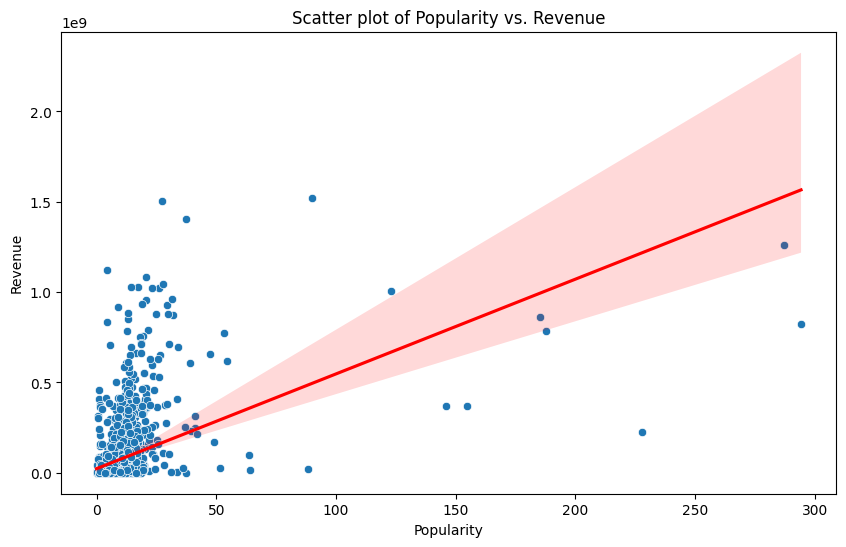

In [26]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='popularity', y='revenue', data=trainingData)

# Adding a trend line to see the correlation more clearly
sns.regplot(x='popularity', y='revenue', data=trainingData, scatter=False, color='red')

plt.title('Scatter plot of Popularity vs. Revenue')  # Set the title of the plot
plt.xlabel('Popularity')  # Set the x-axis label
plt.ylabel('Revenue')  # Set the y-axis label
plt.show()  # Display the plot

In [27]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Remove 'id' column
trainingData = trainingData.drop('id', axis=1)

# Replace zero 'budget' and 'runtime' with the median (or mean)
for col in ['budget', 'runtime']:
    trainingData[col] = trainingData[col].replace(0, np.nan)  # Replace 0 with NaN
    median_value = trainingData[col].median()
    trainingData[col] = trainingData[col].fillna(median_value)  # Replace NaNs with the median

# Log transform 'revenue' to reduce the effect of outliers
trainingData['log_revenue'] = np.log1p(trainingData['revenue'])

# Feature scaling
scaler = StandardScaler()
numeric_cols = ['budget', 'popularity', 'runtime']  # list numeric columns
trainingData[numeric_cols] = scaler.fit_transform(trainingData[numeric_cols])

# Now, the 'trainingData' is adjusted and can be used for further modeling.



In [28]:
y = trainingData['revenue']
correlated_columns = ['budget', 'runtime', 'popularity']
X = trainingData.drop(['revenue', 'log_revenue'], axis=1)



In [29]:
import json

def extract_id_from_collection(json_str):
    if pd.isna(json_str) or json_str == '[]':  # Check if the entry is NaN or an empty list
        return np.nan
    try:
        loaded_json = json.loads(json_str.replace("'", "\""))
        if loaded_json and 'id' in loaded_json[0]:
            return loaded_json[0]['id']
        else:
            return np.nan
    except json.JSONDecodeError:
        return np.nan

# Apply the function to the 'belongs_to_collection' column
X['collection_id'] = X['belongs_to_collection'].apply(extract_id_from_collection)

# Now, drop the original 'belongs_to_collection' column and any other non-numeric columns
X = X.drop('belongs_to_collection', axis=1)
X = X.select_dtypes(include=[np.number])

# Handle any NaN values created during the process
X = X.fillna(0)  # or you can choose to fill with median or mean

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#reg_all = LinearRegression()
#reg_all.fit(X_train, y_train)
#y_pred = reg_all.predict(X_test)

#xgb_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.2,
#                max_depth = 5, alpha = 1, n_estimators = 200)

#xgb_reg.fit(X_train, y_train)


# Define the RMSLE score function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


# Create the RMSLE scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Initialize the base model
rf = RandomForestRegressor(n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_depth=10, bootstrap=False)

rf.fit(X_train, y_train)
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 3000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Execute the random search
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,  # You can choose different number of iterations
                               cv=3,  # You can change the number of folds here
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,  # Use all available cores
                              scoring=rmsle_scorer)

# Fit the random search model on your training data (X_train, y_train)
rf_random.fit(X_train, np.log1p(y_train))  # using log1p transformation on y_train


# View the best parameters from fitting the random search
best_params = rf_random.best_params_
print(f"Best parameters found: {best_params}")

# Retrieve the best model
rf_optimized = rf_random.best_estimator_

# Predict on the test set using the optimized model
log_predictions_optimized = rf_optimized.predict(X_test)
predictions_optimized = np.expm1(log_predictions_optimized)  # Apply inverse log transformation

# Calculate the RMSLE on the test set
rmsle_optimized_score = rmsle(y_test, predictions_optimized)
'''
y_pred = rf.predict(X_test)
rf_score = rmsle(y_test, y_pred)
# Print the optimized RMSLE score
#print(f"The optimized RMSLE score is: {rmsle_optimized_score}")
print(f"The RMSLE score of the base model is: {rf_score}")



The RMSLE score of the base model is: 2.4543080576582694


In [31]:
#compute accuracy as proportion of rediction within given range
lower_bound = y_test * 0.8
upper_bound = y_test * 1.2

within_range = np.logical_and(y_pred >= lower_bound, y_pred <= upper_bound)

accuracy_within_range = np.mean(within_range)

print(f"accuracy within 80% of target variable: {accuracy_within_range:.2%} ")

accuracy within 80% of target variable: 11.60% 


In [32]:
test_ids = testingData['id'].copy()

test_data = testingData.copy().drop('id', axis=1)

# Replace zero 'budget' and 'runtime' with the median (or mean)
for col in ['budget', 'runtime']:
    test_data[col] = test_data[col].replace(0, np.nan)  # Replace 0 with NaN
    median_value = trainingData[col].median()  # Use median from the training data
    test_data[col] = test_data[col].fillna(median_value)  # Replace NaNs with the median

# Feature scaling (use the same scaler object as you used for training data)
# Make sure to exclude 'log_revenue' from the list of columns to scale
numeric_cols = ['budget', 'popularity', 'runtime']  # 'log_revenue' should not be included
test_data[numeric_cols] = scaler.transform(test_data[numeric_cols])

# Apply the same JSON extraction to 'belongs_to_collection'
test_data['collection_id'] = test_data['belongs_to_collection'].apply(extract_id_from_collection)

# Now, drop the original 'belongs_to_collection' column and any other non-numeric columns
test_data = test_data.drop('belongs_to_collection', axis=1)
test_data = test_data.select_dtypes(include=[np.number])

# Handle any NaN values created during the process (use the same method as training data)
test_data = test_data.fillna(0)

# Predict on the preprocessed test_data
test_data_pred = rf.predict(test_data)

df = pd.DataFrame({"id": test_ids,
                   "revenue": test_data_pred})

df.to_csv('/DAT158/oblig2/submission.csv', index=False)

In [33]:
import joblib

# Assuming rf_optimized is your trained and optimized model
joblib.dump(rf, 'rf_model.joblib')


['rf_model.joblib']

In [34]:

model = joblib.load('rf_model.joblib')

# Function to process input and make predictions
def predict(input_data):
    # Convert input data to DataFrame or perform any necessary preprocessing
    # input_df = pd.DataFrame([input_data])
    
    # Make prediction
    prediction = model.predict(input_data)
    
    return prediction

In [35]:
# Title of the web app
st.title('Revenue Prediction Model')

# Get user input
budget = st.number_input('Enter the budget')
popularity = st.number_input('Enter the popularity')
runtime = st.number_input('Enter the runtime')

# When 'Predict' is clicked, make the prediction and display it
if st.button('Predict'):
    input_data = pd.DataFrame([[budget, popularity, runtime]], columns=['budget', 'popularity', 'runtime'])
    prediction = predict(input_data)
    st.success(f'The predicted revenue is ${prediction[0]:,.2f}')
